# 준비

## 라이브러리

In [65]:
# os
import os
from glob import glob

# 기본
import torch
import random
import numpy as np
from tqdm.notebook import tqdm

# eda
import cv2
import matplotlib.pyplot as plt

# dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# modeling
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score

## 기본 설정

### SEED

In [72]:
seed=50
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed); print("set seed :",seed)

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu");print(device)

set seed : 50
cuda


## 데이터

### 데이터 확인

In [35]:
data_path = "D:/Dataset/dataset/Kaggle/Chest X-Ray Images (Pneumonia)/"

train_path = data_path + "train/"
valid_path = data_path + "val/"
test_path = data_path + "test/"

In [36]:
glob(train_path+"*")

['D:/Dataset/dataset/Kaggle/Chest X-Ray Images (Pneumonia)/train\\NORMAL',
 'D:/Dataset/dataset/Kaggle/Chest X-Ray Images (Pneumonia)/train\\PNEUMONIA']

In [37]:
# 각 폴더별 데이터 개수 확인
for dt in ["train/", "val/", "test/"]:
    for lt in ["NORMAL/", "PNEUMONIA/"]:
        print(f"{dt}_{lt}_imgs_counts               :", len(glob(data_path+dt+lt+"*")))

train/_NORMAL/_imgs_counts               : 1341
train/_PNEUMONIA/_imgs_counts               : 3875
val/_NORMAL/_imgs_counts               : 8
val/_PNEUMONIA/_imgs_counts               : 8
test/_NORMAL/_imgs_counts               : 234
test/_PNEUMONIA/_imgs_counts               : 390


In [38]:
all_normal_imgs = [] # 모든 정상 이미지 리스트
all_penumonia_imgs = [] # 모든 폐렴 이미지 리스트

for cat in ["train/", "val/", "test/"]:
    data_cat_path = data_path + cat
    
    normal_imgs = glob(data_cat_path+"NORMAL/*")
    penumonia_imgs = glob(data_cat_path+"PNEUMONIA/*")
    
    all_normal_imgs.extend(normal_imgs)
    all_penumonia_imgs.extend(penumonia_imgs)
    
print("정상 이미지 개수 : ",len(all_normal_imgs))
print("폐렴 이미지 개수 : ",len(all_penumonia_imgs))

정상 이미지 개수 :  1583
폐렴 이미지 개수 :  4273


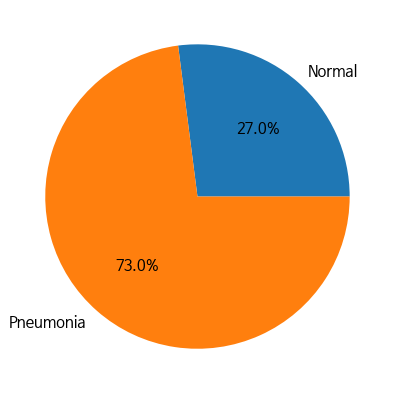

In [40]:
plt.rc("font", size=15)
plt.figure(figsize=(7,7))

label = ["Normal", "Pneumonia"]

plt.pie([len(all_normal_imgs), len(all_penumonia_imgs)], labels=label, autopct="%.1f%%");

In [64]:
def show_image(img_paths, rows=2, cols=3):
    plt.rc("font", size=8)
    plt.figure(figsize=(15,8))
    
    for ids, img_path in enumerate(img_paths):
        img = cv2.imread(img_path)
        ax = plt.subplot(rows, cols, ids+1)
        plt.imshow(img)
        plt.axis("off")

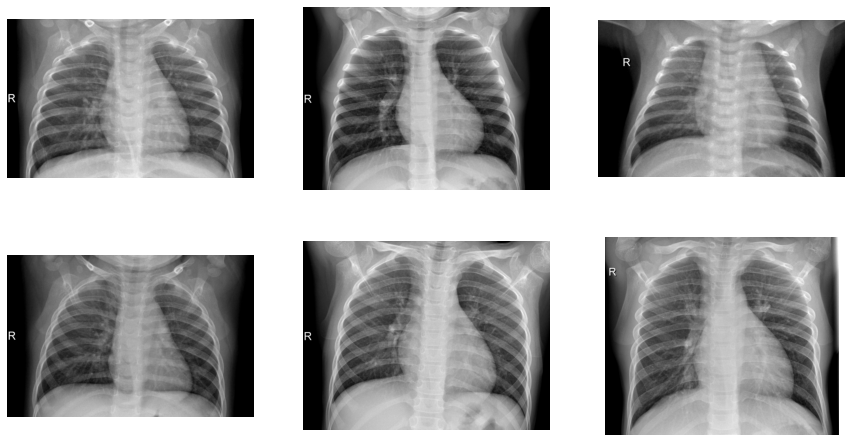

In [62]:
## 정상 이미지
show_image(all_normal_imgs[-6:])

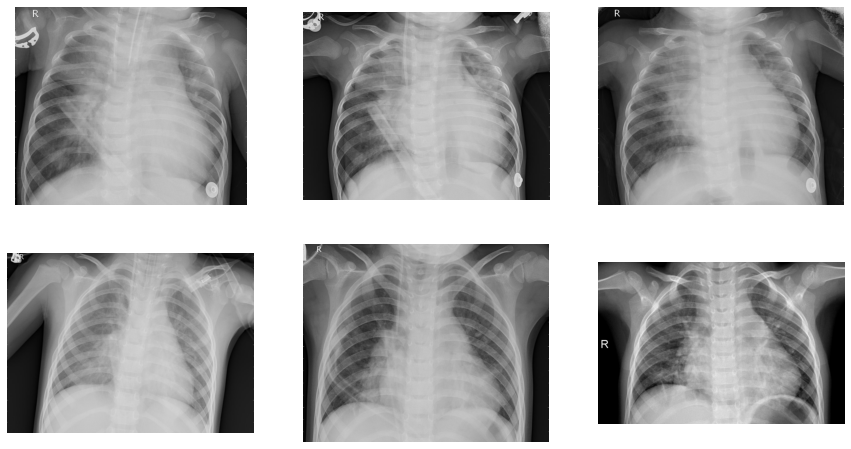

In [63]:
## 폐렴이미지
show_image(all_penumonia_imgs[-6:])

## 데이터 셋

In [110]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
# 제너레이터 시드 고정
g = torch.Generator()
g.manual_seed(0)

In [135]:
# 변환기
transform_train = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.CenterCrop(180),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.    transforms.Resize((250, 250)),
    transforms.CenterCrop(180),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456, 0.406), (0.229, 0.224, 0.225))
])


# dataset
datasets_train = ImageFolder(root=train_path, transform=transform_train)
datasets_valid = ImageFolder(root=valid_path, transform=transform_test)

# dataloader
BATCH_SIZE = 16
loader_train = DataLoader(dataset=datasets_train, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=0)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=0)

# 모델링

## 베이스 라인

In [136]:
# basemodel
model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=2);model = model.to(device)
print("파라미터 개수 : ",sum(param.numel() for param in model.parameters()))

# 손실함수, 옵티마이저
losses = nn.CrossEntropyLoss()
optimizers =torch.optim.Adam(model.parameters(), lr=0.01)

Loaded pretrained weights for efficientnet-b0


In [144]:
def train(model, loader_train, loader_valid, losses, optimizers, scheduler=None, epochs=10, save_file="model_state_dict.pth"):
    valid_loss_min = np.inf
    # 에폭
    for epoch in range(epochs):
        print(f"epoch [{epoch+1}/{epochs}]\n --------------------------------------")
        
        # == 모델 훈련 mode ==
        model.train()
        epoch_train_loss = 0
        
        # 배치
        for images, labels in tqdm(loader_train):
        
            # 데이터를 장치에 할당
            images = images.to(device)
            labels = labels.to(device)
            # opt 값 초기화
            optimizers.zero_grad()
            
            outputs = model(images) # 순전파
            loss = losses(outputs, labels) # 손실계산
            epoch_train_loss += loss.item() # 배치 손실값 추가
            loss.backward() # 역전파
            optimizers.step() # 파라미터 갱신
            if scheduler != None: # 스케쥴러 갱신
                scheduler.step()
                
        print(f"\t 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train) : .4f}")
        
        
        # == 모델 검증 mode ==
        model.eval()
        epoch_valid_loss = 0
        preds_list = []
        true_list = []
        
        with torch.no_grad(): # 기울기 계산 X
            for images, labels in loader_valid:
                
                # 장치 할당
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images) # 순전파
                loss = losses(outputs, labels) # 손실값 계산
                epoch_valid_loss += loss.item() # 배치 손실 추가
                
                # 예측, 실제 값
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy()
                true = labels.cpu().numpy()
                
                preds_list.extend(preds)
                true_list.extend(true)
                
        print(f"\t 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train) : .4f}")
        
            # 평가지표 계산
        val_acc = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)
        
        print(f"\t 정확도 : {val_acc: .4f} / 재현율 : {val_recall: .4f} / F1 점수 : {val_f1_score: .4f}")
        
        # == 최적 모델 ==
        if epoch_valid_loss <= valid_loss_min:
            print(f"\t ### 검증 데이터 손실값이 감소하였음 ){valid_loss_min:.4f} ---> {epoch_valid_loss: .4f}. 모델 저장.")
            torch.save(model.state_dict(), save_file) # 모델 가중치 저장
            valid_loss_min = epoch_valid_loss # 갱신
    return torch.load(save_file)

In [145]:
model_state_dict = train(model=model,
                         loader_train=loader_train,
                         loader_valid=loader_valid,
                         losses=losses,
                         optimizers=optimizers)

epoch [1/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1766
	 훈련 데이터 손실값 :  0.1766
	 정확도 :  0.6875 / 재현율 :  0.3750 / F1 점수 :  0.5455
	 ### 검증 데이터 손실값이 감소하였음 )inf --->  6.4684. 모델 저장.
epoch [2/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1831
	 훈련 데이터 손실값 :  0.1831
	 정확도 :  0.5000 / 재현율 :  1.0000 / F1 점수 :  0.6667
	 ### 검증 데이터 손실값이 감소하였음 )6.4684 --->  4.9866. 모델 저장.
epoch [3/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1539
	 훈련 데이터 손실값 :  0.1539
	 정확도 :  0.7500 / 재현율 :  0.5000 / F1 점수 :  0.6667
	 ### 검증 데이터 손실값이 감소하였음 )4.9866 --->  1.0567. 모델 저장.
epoch [4/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1449
	 훈련 데이터 손실값 :  0.1449
	 정확도 :  0.5625 / 재현율 :  1.0000 / F1 점수 :  0.6957
epoch [5/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1403
	 훈련 데이터 손실값 :  0.1403
	 정확도 :  0.8125 / 재현율 :  1.0000 / F1 점수 :  0.8421
	 ### 검증 데이터 손실값이 감소하였음 )1.0567 --->  0.4125. 모델 저장.
epoch [6/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1314
	 훈련 데이터 손실값 :  0.1314
	 정확도 :  0.6250 / 재현율 :  1.0000 / F1 점수 :  0.7273
epoch [7/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1347
	 훈련 데이터 손실값 :  0.1347
	 정확도 :  0.9375 / 재현율 :  1.0000 / F1 점수 :  0.9412
	 ### 검증 데이터 손실값이 감소하였음 )0.4125 --->  0.1453. 모델 저장.
epoch [8/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1327
	 훈련 데이터 손실값 :  0.1327
	 정확도 :  0.6250 / 재현율 :  1.0000 / F1 점수 :  0.7273
epoch [9/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1216
	 훈련 데이터 손실값 :  0.1216
	 정확도 :  0.8125 / 재현율 :  1.0000 / F1 점수 :  0.8421
epoch [10/10]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1142
	 훈련 데이터 손실값 :  0.1142
	 정확도 :  0.8125 / 재현율 :  1.0000 / F1 점수 :  0.8421


### 예측 및 평가

In [147]:
# 최적 모델 load
model.load_state_dict(model_state_dict)

# dataset
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

In [151]:
def predict(model, loader_test, return_true=False):
    
    model.eval()
    preds_list = []
    true_list = []

    with torch.no_grad(): 
        for images, labels in loader_valid:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # 순전파

            # 예측, 실제 값
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy()
            true = labels.cpu().numpy()

            preds_list.extend(preds)
            true_list.extend(true)
            
    if return_true:
        return true_list, preds_list
    
    else:
        return preds_list
    
true_list, preds_list = predict(model=model, loader_test=loader_test, return_true=True)

In [152]:
## 평가 결과
print("#"*5, "최종 예측 결과 평가 점수","#"*5)
print(f"정확도 : {accuracy_score(true_list, preds_list):.4f}")
print(f"재현율 : {recall_score(true_list, preds_list):.4f}")
print(f"F1_score : {f1_score(true_list, preds_list):.4f}")

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.9375
재현율 : 1.0000
F1_score : 0.9412


## 성능개선1

### 앙상블

In [169]:
models_list = []

efficientNet_b1 = EfficientNet.from_pretrained("efficientnet-b1", num_classes=2).to(device)
efficientNet_b2 = EfficientNet.from_pretrained("efficientnet-b2", num_classes=2).to(device)
efficientNet_b3 = EfficientNet.from_pretrained("efficientnet-b3", num_classes=2).to(device)

efficientNet_b1 = efficientNet_b1.to(device)
efficientNet_b2 = efficientNet_b2.to(device)
efficientNet_b3 = efficientNet_b3.to(device)

models_list.append(efficientNet_b1)
models_list.append(efficientNet_b2)
models_list.append(efficientNet_b3)
print()
for idx, model in enumerate(models_list):
    num_params = sum(param.numel() for param in model.parameters())
    print(f" 모델{idx+1} 파라미터 개수 : {num_params}")

Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3

 모델1 파라미터 개수 : 6515746
 모델2 파라미터 개수 : 7703812
 모델3 파라미터 개수 : 10699306


### 옵티마이저

In [170]:
from transformers import get_cosine_schedule_with_warmup

In [171]:
## AdamW
losses = nn.CrossEntropyLoss()

optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)

## warmup cosine
epochs=20
scheduler1 = get_cosine_schedule_with_warmup(optimizer1, num_warmup_steps=len(loader_train)*3, num_training_steps=len(loader_train)*epochs)
scheduler2 = get_cosine_schedule_with_warmup(optimizer2, num_warmup_steps=len(loader_train)*3, num_training_steps=len(loader_train)*epochs)
scheduler3 = get_cosine_schedule_with_warmup(optimizer3, num_warmup_steps=len(loader_train)*3, num_training_steps=len(loader_train)*epochs)

### 훈련

In [ ]:
print("-"*10,"첫번째 모델 훈련","-"*10)
model_state_dict = train(model=models_list[0],
                         loader_train=loader_train,
                         loader_valid=loader_valid,
                         losses=losses,
                         optimizers=optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)

models_list[0].load_state_dict(model_state_dict)

print("-"*10,"두번째 모델 훈련","-"*10)
model_state_dict = train(model=models_list[1],
                         loader_train=loader_train,
                         loader_valid=loader_valid,
                         losses=losses,
                         optimizers=optimizer2,
                         scheduler=scheduler2,
                         epochs=epochs)

models_list[1].load_state_dict(model_state_dict)

print("-"*10,"세번째 모델 훈련","-"*10)
model_state_dict = train(model=models_list[2],
                         loader_train=loader_train,
                         loader_valid=loader_valid,
                         losses=losses,
                         optimizers=optimizer3,
                         scheduler=scheduler3,
                         epochs=epochs)

models_list[2].load_state_dict(model_state_dict)

---------- 첫번째 모델 훈련 ----------
epoch [1/20]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.3136
	 훈련 데이터 손실값 :  0.3136
	 정확도 :  0.5625 / 재현율 :  1.0000 / F1 점수 :  0.6957
	 ### 검증 데이터 손실값이 감소하였음 )inf --->  1.4763. 모델 저장.
epoch [2/20]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1341
	 훈련 데이터 손실값 :  0.1341
	 정확도 :  0.7500 / 재현율 :  1.0000 / F1 점수 :  0.8000
	 ### 검증 데이터 손실값이 감소하였음 )1.4763 --->  0.6342. 모델 저장.
epoch [3/20]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.1085
	 훈련 데이터 손실값 :  0.1085
	 정확도 :  0.8750 / 재현율 :  1.0000 / F1 점수 :  0.8889
	 ### 검증 데이터 손실값이 감소하였음 )0.6342 --->  0.2334. 모델 저장.
epoch [4/20]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.0902
	 훈련 데이터 손실값 :  0.0902
	 정확도 :  0.8125 / 재현율 :  1.0000 / F1 점수 :  0.8421
epoch [5/20]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.0754
	 훈련 데이터 손실값 :  0.0754
	 정확도 :  0.6875 / 재현율 :  1.0000 / F1 점수 :  0.7619
epoch [6/20]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.0662
	 훈련 데이터 손실값 :  0.0662
	 정확도 :  0.8125 / 재현율 :  1.0000 / F1 점수 :  0.8421
epoch [7/20]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]

	 훈련 데이터 손실값 :  0.0630
	 훈련 데이터 손실값 :  0.0630
	 정확도 :  0.6875 / 재현율 :  1.0000 / F1 점수 :  0.7619
epoch [8/20]
 --------------------------------------


  0%|          | 0/326 [00:00<?, ?it/s]